# Using Basic Tensor Flow
In this notebook, we will start to build our skills with tensorflow with a primitive example, and work our way to more expressive architectures. We will also look at some of the methods for using TensorFlow with a simplified interface. 

To install tensorflow via anaconda use the command:
- `conda install -c conda-forge tensorflow`

Let's first create a linear regression algorithm in TensorFlow, just to show how its setup under the hood.

In [1]:
from sklearn.datasets import load_diabetes
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

ds = load_diabetes()
ds.target = ds.target.reshape((-1,1)) # make this explicit

print(ds.data.shape)
print(ds.target.shape, ds.target.dtype, min(ds.target), max(ds.target))

ds.data /= np.max(ds.data)

n_observations, n_features = ds.data.shape

(442, 10)
(442, 1) float64 [ 25.] [ 346.]


In [2]:
import tensorflow as tf

print(tf.__version__)

session = tf.InteractiveSession()

0.11.0rc2


In [3]:
batchsize = 100 #regular python variable

#setup some tensor flow variables in computation graph
X = tf.placeholder(tf.float32, shape=(batchsize, n_features))
y = tf.placeholder(tf.float32, shape=(batchsize, 1))

# define a namespace of scope
with tf.variable_scope('linear_regression'):
    # these variables cannot be redefined after this call
    # running this block again returns an error
    
    # define variables in this tensorflow scope
    W = tf.get_variable('weights', 
                        (n_features,1), 
                        initializer=tf.random_normal_initializer())
    
    # define other operations of these variables
    yhat = tf.matmul(X,W)
    objective = tf.reduce_mean((y-yhat)**2)
    
# define some operations on the 
opt = tf.train.AdamOptimizer()
opt_operation = opt.minimize(objective)

In [4]:
session.run(tf.initialize_all_variables())
for _ in range(1000):
    idx = np.random.choice(n_observations, batchsize) 
    _, obj_val = session.run([opt_operation,objective],
                             feed_dict={X:ds.data[idx],y:ds.target[idx]})

In [5]:
print(obj_val)
print(W)

W_vals = session.run(W)
print(W_vals)

29203.0
[[ 0.41920722]
 [-0.65132737]
 [ 0.61349112]
 [ 1.43049049]
 [ 0.88769495]
 [ 0.39079744]
 [-1.95032954]
 [ 1.73670959]
 [-0.00686819]
 [ 0.61375576]]


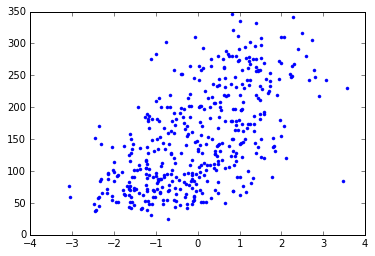

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

y_hat = ds.data @ W_vals

plt.plot(y_hat,ds.target,'.')

# Making TensorFlow Easier to Use
Well, once we know the overall architecture of the problem we want to sovle, can we make the use of TensorFlow easier? Sure. Let's emulate the functionality of scikit-learn.

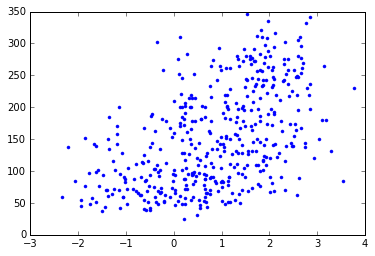

In [12]:
import tensorflow as tf
class TFLinearRegressor():
    def __init__(self, C=0.1, batchsize=100, epochs=1000):
        # setup regularizers
        self.C = C
        self._W = []
        self._b = []
        self.batchsize = batchsize
        self.epochs = epochs
        
    def predict(self,X):
        return X @ self._W + self._b
        
    def fit(self,X,y):
        
        n_observations, n_features = X.shape
        y_new = y.reshape((n_observations,1))
        
        #setup some tensor flow variables in computation graph
        Xtf = tf.placeholder(tf.float32, shape=(self.batchsize, n_features))
        ytf = tf.placeholder(tf.float32, shape=(self.batchsize, 1))
        
        # define a namespace of scope, set reuse true so that this object can be remade
        with tf.variable_scope('TFLinearRegressor') as scope:
            
            Ctf = tf.constant(dtype=tf.float32,shape=(1,1),value=self.C)

            try:
                # define variables in this tensorflow scope
                W = tf.get_variable('weights', 
                                    (n_features,1), 
                                    initializer=tf.random_normal_initializer())

                b = tf.get_variable('bias', 
                                    (1,1),
                                    initializer=tf.random_normal_initializer())

            except ValueError:
                # we have already called this, just reuse it!
                
                scope.reuse_variables()
                # define variables in this tensorflow scope
                W = tf.get_variable('weights', 
                                    (n_features,1), 
                                    initializer=tf.random_normal_initializer())

                b = tf.get_variable('bias', 
                                    (1,1),
                                    initializer=tf.random_normal_initializer())

            # define other operations of these variables
            yhat = tf.matmul(Xtf,W) + b
            objective = tf.reduce_mean((ytf-yhat)**2) + Ctf*tf.reduce_mean(W**2)

        # define some operations to minimize
        opt_operation = tf.train.AdamOptimizer().minimize(objective)
        
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            for _ in range(1000):
                idx = np.random.choice(n_observations, self.batchsize) 
                _, obj_val = sess.run([opt_operation,objective],
                                 feed_dict={Xtf:X[idx],ytf:y_new[idx]})
                
            self._W, self._b = sess.run([W,b])
        
reg = TFLinearRegressor(epochs=2000,C=0.001)
reg.fit(ds.data,ds.target)
yhat = reg.predict(ds.data)

plt.plot(yhat,ds.target,'.')

# Integrating with Contributors: Scikit-Flow, TFLearn
TensorFlow has some programming quirks...
As you can see there is a lot of syntax around using TensorFlow correctly that we would ideally like to abstract away from the programmer while learning the tool. Clearly, there is a tradeoff here between having more control over the learning algorithm and learning parameters, and having an easy to use developer interface.

Enter, `Scikit-Flow` or `SKFlow` or `TF Learn`, which is now a core part of the tensorflow learning package. Lets see a simple example of using it. 

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


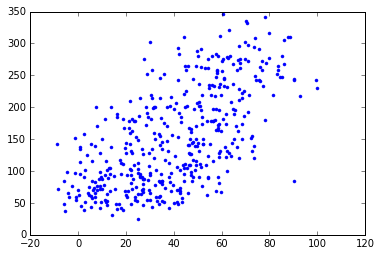

In [13]:
from tensorflow.contrib import learn

X = ds.data.astype(np.float32)
y = ds.target.astype(np.float32)

# Build model (just  a simple linear regressor)
feature_columns = learn.infer_real_valued_columns_from_input(X)
reg = learn.LinearRegressor(
    feature_columns=feature_columns)

# Fit
reg.fit(X, y, steps=5000, batch_size=50)

# Predict (unfortunate, but this is the syntax)
#   the iterable output can be a real advantage for larger data
#   essentially delaying memory transfer and computation to later
#   but here it is just wrapper to get it in a similar output 
#   format to sklearn (however, it is NOT a numpy array, just a list)
yhat = list(reg.predict(X, as_iterable=True))

plt.plot(yhat,y,'.')

### Custom models
However, we really do not lose too much of the expressive nature of TensorFlow because we can create **custom** models for it. For eaxmple, if we wanted to create our own tensorflow model, 
and then use SKFlow to optimize it, we could!

Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.


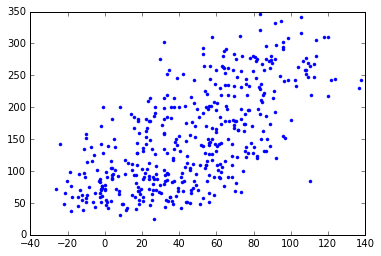

In [14]:

import tensorflow as tf 
from tensorflow.contrib import learn

def my_model(Xin,yin):
    #  * `(features, targets) -> (predictions, loss, train_op)`
    prediction, loss = learn.models.linear_regression(Xin,yin)
    
    train_op = tf.contrib.layers.optimize_loss(
            loss, tf.contrib.framework.get_global_step(),
            optimizer='Adam', learning_rate=0.01)
    
    return prediction, loss, train_op

reg = learn.Estimator(model_fn=my_model)

# Fit
reg.fit(X, y, steps=5000, batch_size=50)

# Predict
yhat = list(reg.predict(X, as_iterable=True))

plt.plot(yhat,y,'.')

Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.


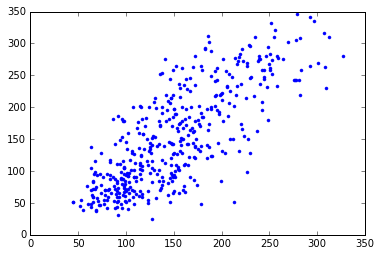

In [15]:
import tensorflow as tf 
from tensorflow.contrib import learn
from tensorflow.contrib import layers

X = ds.data.astype(np.float32)
y = ds.target.astype(np.float32)

def my_model(Xin,yin):
    #  * `(features, targets) -> (predictions, loss, train_op)`
    
    # we can use functions from SKFlow to add layers and complexity to the model
    features = layers.stack(Xin, layers.fully_connected, [7, 15, 10])

    # now define the output as a linear regression from hidden neurons
    prediction, loss = learn.models.linear_regression(features,yin) 
    
    train_op = layers.optimize_loss(
            loss, tf.contrib.framework.get_global_step(),
            optimizer='Adam', learning_rate=0.01)

    return prediction, loss, train_op

reg = learn.Estimator(model_fn=my_model)

# Fit
reg.fit(X, y, steps=5000, batch_size=128)

# Predict
yhat = list(reg.predict(X, as_iterable=True))

plt.plot(yhat,y,'.')

In [46]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)

yhat = np.zeros(y.shape)
for train,test in cv.split(X,y):
    reg.fit(X[train],y[train],steps=5000, batch_size=128)
    yhat[test] = np.array(list(reg.predict(X[test], as_iterable=True))).reshape((-1,1))

Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.
Instructions for updating:
Use mean_squared_error.


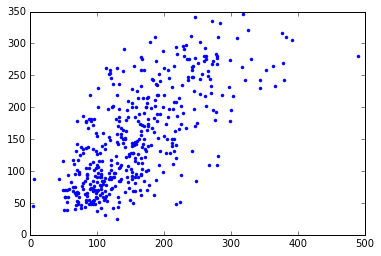

In [47]:
plt.plot(yhat,y,'.')

# Skip this, not working yet...
# Alternatives to TensorFlow
There are many libraries out there, but one that is pretty eye catching and easy to use is the MXNet integration with GraphLab. Still very expressive code, but it works out of the box with simple syntax. 

You will probably need to change targets to Python 2.7 if running this code here. 

**This code is not working...** Looks like MXNet is not a great workaround for graphlab... yet.

In [1]:
from __future__ import print_function
from sklearn.datasets import load_diabetes
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

ds = load_diabetes()
ds.target = ds.target.reshape((-1,1)) # make this explicit

print(ds.data.shape)
print(ds.target.shape, ds.target.dtype, min(ds.target), max(ds.target))

ds.data /= np.max(ds.data)

n_observations, n_features = ds.data.shape

(442, 10)
(442, 1) float64 [ 25.] [ 346.]


In [8]:
import graphlab as gl

sf = gl.SFrame(ds.data)
sf['target'] = ds.target

In [9]:
sf = sf.unpack('X1')
sf

target,X1.0,X1.1,X1.2,X1.3,X1.4
[151.0],0.191540276146,0.25494557708,0.310361841402,0.1100285537,-0.222465645438
[75.0],-0.00946745591137,-0.22456908279,-0.258939492912,-0.132441777608,-0.0425011799042
[141.0],0.429094868577,0.25494557708,0.223611161888,-0.0285259213331,-0.229387355651
[206.0],-0.4480297804,-0.22456908279,-0.0583285465344,-0.184399705746,0.0613244732884
[135.0],0.0270794044627,-0.22456908279,-0.183032648337,0.1100285537,0.0197942120114
[97.0],-0.466303210587,-0.22456908279,-0.204720318215,-0.0978031588498,-0.347056429269
[138.0],-0.228748618156,0.25494557708,-0.237251823033,-0.0804838494706,-0.2017005148
[63.0],0.319454287455,0.25494557708,-0.00953128930752,0.335179575629,0.45586195542
[110.0],0.209813706333,0.25494557708,0.310361841402,-0.201719015125,-0.0701880207556
[310.0],-0.356662629465,-0.22456908279,0.196501574539,-0.167080396366,-0.0632663105427


In [ ]:
from graphlab import mxnet as mx

# Define the network symbol, equivalent to linear regression
net = mx.symbol.Variable('data')
net = mx.symbol.FullyConnected(data=net, name='fc1', num_hidden=1)
net = mx.symbol.LinearRegressionOutput(data=net, name='lr')

# Prepare the input iterator from SFrame
# `data_name` must match the first layer's name of the network.
# `label_name` must match the last layer's name plus "_label".

# this kills the kernel on my machine, not sure why!!!
dataiter = mx.io.SFrameIter(sf, data_field=['X1.0','X1.1','X1.2','X1.3','X1.4'], 
                            label_field='target', 
                            data_name='data', 
                            label_name='lr_label',
                            batch_size=1)



[INFO] graphlab.mxnet.base: CUDA support is currently not available on this platform. GPU support is disabled.


In [ ]:
# Train the network
model = mx.model.FeedForward.create(symbol=net, X=dataiter, num_epoch=20,
                                  learning_rate=1e-2,
                                  eval_metric='rmse')

# Make prediction
model.predict(dataiter)